# Basic: Recovering the 12-6 Lennard-Jones Potential between Two Point Particles

This tutorial demonstrates the basics of the potential-matching force field optimization framework.  Our system will contain two point particles, to which we will assign parameters for a 12-6 Lennard-Jones interaction potential to use as target data. We will then use the force field optimization framework to attempt to recover the parameters we assigned to this potential.

---

Potential functions feature many functional forms.  These functional forms can be defined as subclasses of the  `Forcefield` (abstract) class, where the parameters required for instantiation are defined as well as a function for evaluating the potential energy as a function of inter-particle separation.  Several pre-defined `Forcefield` subclasses are available within NanoOpt, including the `Mie` class, which defines the mie potential.  We can use this subclass, setting the exponents `n` and `m` to 12 and 6 respectively, to define a 12-6 Lennard-Jones potential.

Parameters passed as arguments during `Forcefield` instantiation are instances of the `Parameter` class.  Each parameter must be provided with a `value`, as well as an `upper` and `lower` bound to be used during optimization.  Alternatively, a parameter may be set as `fixed`, whereby these `upper` and `lower` bounds are not required as the parameter will not be altered during optimization.

Here, since we are defining our target forcefield, as opposed to one we want to optimize, we will set each parameter to be `fixed`.  The values we provide here are those we hope to recover during the optimization.

In [1]:
import nanoparticle_optimization as np_opt

sigma_target = np_opt.Parameter(value=5.0, fixed=True)
epsilon_target = np_opt.Parameter(value=5.0, fixed=True)
n_target = np_opt.Parameter(value=12.0, fixed=True)
m_target = np_opt.Parameter(value=6.0, fixed=True)

lj_12_6 = np_opt.Mie(sigma=sigma_target, epsilon=epsilon_target, n=n_target, m=m_target)

The `Target` class is used to define a set of target data to be used during an optimization, which takes as arguments a list of `separations` and `potential` values.  These two lists must have the same length, where each value in `potential` corresponds to the interaction potential at a corresponding inter-particle separation in `separation`.  For this tutorial, we will define our target data by generating a set of 50 points along the 12-6 LJ potential curve.

Text(0,0.5,'U')

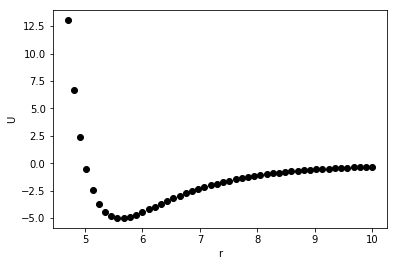

In [2]:
import numpy as np

from nanoparticle_optimization.target import Target

separations = np.linspace(4.7, 10.0, 50)
potential = lj_12_6.calc_potential(separations)
target = Target(separations=separations, potential=potential)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.xlabel('r')
plt.ylabel('U')

The `System` class defines a system of two mBuild `Compounds`.  This class contains functions for calculating the interaction potential between the two `Compounds`, using a provided `Forcefield`, that are compared against a `Target` in an `Optimization`.

If only one mBuild `Compound` is passed to `System` upon instantiation, a second copy of this `Compound` is automatically generated.

In [3]:
import mbuild as mb

point_particle = mb.Compound(pos=np.zeros(3))
system = np_opt.System(point_particle)

Next, we define the `Forcefield` that we want to optimize.  The `values` that we provide to `sigma`, `epsilon`, `n`, and `m` will be used as starting values in the optimization.  After optimizing, the values we defined in our target `Forcefield` should be recovered.  Since we only want to optimize `sigma` and `epsilon`, we provide each of these `Parameters` with an `upper` and `lower` bound and set `n` and `m` to fixed values of 12 and 6.

In [4]:
from nanoparticle_optimization import Mie, Parameter

sigma = Parameter(value=2.5, upper=10.0, lower=2.0)
epsilon = Parameter(value=2.5, upper=10.0, lower=2.0)
n = Parameter(value=12.0, fixed=True)
m = Parameter(value=6.0, fixed=True)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

The final class in the potential-matching forcefield optimization framework is the `Optimization` class.  This class can be used to perform many optimizations as provided by the [`scipy.optimize`](https://docs.scipy.org/doc/scipy-0.14.0/reference/optimize.html) module.

In [5]:
from nanoparticle_optimization.optimization import Optimization

We can provide a number of `configurations` to sample at each separation as an argument during instantiation of an `Optimization`.  Because our system contains only point particles, we set this value to 1.

Additionally, we'll plot our initial (unoptimized) force field, just to show that we are starting with values that are far from optimal.

Text(0,0.5,'U')

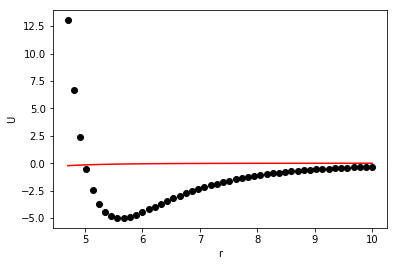

In [6]:
optimization = Optimization(ff, system, target, configurations=1)

starting_potential = optimization.forcefield.calc_potential(separations)

plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.plot(separations, starting_potential, marker='None', color='red')
plt.xlabel('r')
plt.ylabel('U')

The optimization is launched by executing the `optimize` function. By default the optimization will first perform a brute force search (using the bounds provided to each `Parameter` as well as the `gridpoints` argument to `optimize`), followed by a polishing stage that can utilize many of the minimization algorithms contained in SciPy.

In [7]:
help(optimization.optimize)

Help on method optimize in module nanoparticle_optimization.optimization:

optimize(brute_force=True, verbose=False, gridpoints=10, polishing_function=<function fmin at 0x6257a6c80>, threads=1, cut=None, r_dependent_sampling=False, sample_until=0.1, **kwargs) method of nanoparticle_optimization.optimization.Optimization instance
    Optimize force field parameters via potential matching
    
    Force field parameters are optimized by matching the interaction potential
    of the nanoparticle system defined in the System class with a target defined
    in the Target class. A brute force optimization is performed along a grid,
    ensuring that the optimization does not get stuck in local minima. A
    "polishing" function is then used with the result of the brute force
    optimization as an initial state. All optimizations are performed utilizing
    Scipy's optimize module (https://docs.scipy.org/doc/scipy/reference/
    optimize.html#module-scipy.optimize).
    
    Parameters
    -

However, for this simple minimization, we'll skip the brute force portion and jump straight into the polishing stage. Here, we'll use the default polishing function which is a Nelder-Mead simplex algorithm.

In [8]:
optimization.optimize(brute_force=False, verbose=True)

epsilon: 2.5

sigma: 2.5

Residual: 0.9760058201213598


epsilon: 2.625

sigma: 2.5

Residual: 0.9748273776696379


epsilon: 2.5

sigma: 2.625

Residual: 0.9681093313896996


epsilon: 2.625

sigma: 2.625

Residual: 0.966552307061549


epsilon: 2.6875

sigma: 2.6875

Residual: 0.9607872115299616


epsilon: 2.5625

sigma: 2.8125

Residual: 0.9513966162598406


epsilon: 2.53125

sigma: 2.96875

Residual: 0.9347752634271627


epsilon: 2.71875

sigma: 3.03125

Residual: 0.9216021577168476


epsilon: 2.828125

sigma: 3.234375

Residual: 0.8872023364306244


epsilon: 2.671875

sigma: 3.515625

Residual: 0.8390443192565429


epsilon: 2.6640625

sigma: 3.9296875

Residual: 0.7340132176782992


epsilon: 2.9609375

sigma: 4.1953125

Residual: 0.6243931325865874


epsilon: 3.17578125

sigma: 4.80859375

Residual: 0.35543817134737377


epsilon: 3.01171875

sigma: 5.50390625

Residual: 0.4804530182690718


epsilon: 3.5234375

sigma: 6.3828125

Residual: 0.937918281703006


epsilon: 2.87890625

sigma

Now, let's plot our result and output the `sigma` and `epsilon` parameters the optimization settled on.

sigma = 5.000
epsilon = 5.000


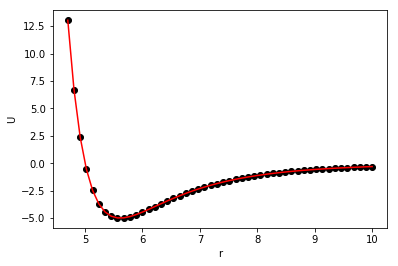

In [9]:
matched_potential = np.array([optimization.forcefield.calc_potential(r) for r in separations])

plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.plot(separations, matched_potential, marker='None', color='red')
plt.xlabel('r')
plt.ylabel('U')

print('sigma = {:.3f}'.format(optimization.forcefield['sigma']))
print('epsilon = {:.3f}'.format(optimization.forcefield['epsilon']))

As we can see, the optimization was able to recover both the `sigma` and `epsilon` values of our 12-6 LJ potential.